# Введение в искусственные нейронные сети
# Урок 4. Сверточные нейронные сети

## Практическое задание

Вариант 1. (простой)

- обучить сверточную нейронную сеть в стиле AlexNet (с падением размера ядра свертки и последовательностью блоков свертка-пулинг  (conv-pool)-(conv-pool)-...) на датасете fashion-mnist
- оценить рост точности при увеличении ширины сети (больше ядер)
- оценить рост точности при увеличении глубины сети (больше слоев)
- сравнить с точностью полносвязной сети для этой выборки
    </li>

Вариант 2. (сложный)
- реализовать нейронную сеть или стек из сверток (Concatenate) на сifar10.
- оценить рост точности при увеличении ширины сети (больше ядер), больше нитей.
- оценить рост точности при увеличении глубины сети (больше слоев)
    </li>
</ol>

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import models, layers
from tensorflow.keras.layers import Conv2D, Input
from tensorflow.keras.layers import GlobalMaxPooling2D, MaxPooling2D, AveragePooling2D, GlobalAveragePooling2D 

print(tf.__version__)

2.5.0


In [2]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

In [3]:
# загрузка тренировочных и тестовых данных
(train_images,train_labels),(test_images,test_labels)=fashion_mnist.load_data()

# конвертация чисел из uint8 в float32
train_images = train_images.astype('float32')
test_images = test_images.astype('float32')

# нормализация данных [0, 1]
train_images /= 255 
test_images /= 255 

print(f'train_images shape:\t{train_images.shape}\n'
      f'test_images shape:\t{test_images.shape}\n\n')

# трансформация лейблов в one-hot encoding
train_labels = to_categorical(train_labels, 10) 
test_labels = to_categorical(test_labels, 10) 

# изменение размерности массива в 4D массив
train_images = train_images.reshape(train_images.shape[0], 28,28,1)
test_images = test_images.reshape(test_images.shape[0], 28,28,1)

print(f'train_images shape:\t{train_images.shape}\n'
      f'test_images shape:\t{test_images.shape}\n'
      f'train_labels shape:\t{train_labels.shape}\n'
      f'test_labels shape:\t{test_labels.shape}') 

train_images shape:	(60000, 28, 28)
test_images shape:	(10000, 28, 28)


train_images shape:	(60000, 28, 28, 1)
test_images shape:	(10000, 28, 28, 1)
train_labels shape:	(60000, 10)
test_labels shape:	(10000, 10)


In [13]:
def model_width_analysis (filters_1, filters_2, epochs=21):
    """Анализ ширины модели"""
    model_name=f'model_wa{filters_1}_{filters_2}'
    # инициализация пустой модели
    model = Sequential(name=model_name)

    # первый сверточный слой
    model.add(layers.Conv2D(filters_1, kernel_size=(5, 5), strides=(1, 1), activation='tanh', input_shape=(28,28,1), padding="same"))

    # второй пуллинговый слой
    model.add(layers.AveragePooling2D(pool_size=(2, 2), strides=(1, 1), padding='valid'))

    # пятый полносвязный слой
    model.add(layers.Conv2D(filters_2, kernel_size=(5, 5), strides=(1, 1), activation='tanh', padding='valid'))

    # сглаживание CNN выхода чтобы можно было его присоединить к полносвязногому слою
    model.add(layers.Flatten())

    # шестой полносвязный слой
    model.add(layers.Dense(84, activation='tanh'))

    # выходной слой с функцией активации softmax
    model.add(layers.Dense(10, activation='softmax'))

    # компилияция модели
    model.compile(loss=keras.losses.categorical_crossentropy, optimizer='SGD', metrics=["accuracy"])


    hist = model.fit(x=train_images,
                     y=train_labels,
                     epochs=epochs,
                     batch_size=128,
                     validation_data=(test_images,
                                      test_labels),
                     verbose=1)

    test_score = model.evaluate(test_images, test_labels)
    
    print(f"Test loss {test_score[0]:.4f}, accuracy {test_score[1] * 100:.2f}")  
    return model_name, model, hist, test_score

    
def model_depth_analysis(n, epochs=21):
    """Анализ глубины модели"""
    model_name=f'model_da{n}'
    model = Sequential()
    
    for _ in range(n):
        model.add(layers.Conv2D(6, kernel_size=(5, 5), strides=(1, 1), activation='tanh', input_shape=(28,28,1), padding="same"))
        model.add(layers.AveragePooling2D(pool_size=(2, 2), strides=(1, 1), padding='valid'))
        model.add(layers.Conv2D(6, kernel_size=(5, 5), strides=(1, 1), activation='tanh', padding='valid'))

    # сглаживание CNN выхода чтобы можно было его присоединить к полносвязногому слою
    model.add(layers.Flatten())

    # шестой полносвязный слой
    model.add(layers.Dense(84, activation='tanh'))

    # выходной слой с функцией активации softmax
    model.add(layers.Dense(10, activation='softmax'))  
    
    # компилияция модели
    model.compile(loss=keras.losses.categorical_crossentropy, optimizer='SGD', metrics=["accuracy"])      
    hist = model.fit(x=train_images,
                     y=train_labels, 
                     epochs=epochs, 
                     batch_size=128, 
                     validation_data=(test_images, test_labels), 
                     verbose=1)  
    
    test_score = model.evaluate(test_images, test_labels) 
    
    print(f"Test loss {test_score[0]:.4f}, accuracy {test_score[1] * 100:.2f}")  
    return model_name, model, hist, test_score


def plot_history(history):
    keys_list = list(history.history.keys())
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error [1000$]')
    plt.plot(history.epoch, 
           np.array(history.history[keys_list[1]]),
           label='train Loss')
    plt.plot(history.epoch, 
           np.array(history.history[keys_list[-1]]),
           label = 'val loss')
    plt.legend()
    #plt.ylim([0, 5])
    plt.show()



## Анализ ширины модели

In [5]:
width_analysis_list = [(2, 4), (5, 10), (8, 16), (10, 20), (15, 30)]
models_dict = {'model_names': [], 'models':[], 'model_historys':[], 'model_test_score':[]}

In [6]:
%time
for f_1, f_2 in width_analysis_list:   
    model_name, model, hist, test_score = model_width_analysis(f_1, f_2)
    models_dict['model_names'].append(model_name)
    models_dict['models'].append(model)
    models_dict['model_historys'].append(hist)
    models_dict['model_test_score'].append(test_score)
    


CPU times: user 4 µs, sys: 1e+03 ns, total: 5 µs
Wall time: 9.06 µs
Epoch 1/21
469/469 [==============================] - 29s 61ms/step - loss: 0.8500 - accuracy: 0.7084 - val_loss: 0.6254 - val_accuracy: 0.7722
Epoch 2/21
469/469 [==============================] - 27s 58ms/step - loss: 0.5487 - accuracy: 0.8061 - val_loss: 0.5448 - val_accuracy: 0.8042
Epoch 3/21
469/469 [==============================] - 27s 58ms/step - loss: 0.4890 - accuracy: 0.8266 - val_loss: 0.4974 - val_accuracy: 0.8266
Epoch 4/21
469/469 [==============================] - 27s 57ms/step - loss: 0.4533 - accuracy: 0.8405 - val_loss: 0.4777 - val_accuracy: 0.8272
Epoch 5/21
469/469 [==============================] - 27s 57ms/step - loss: 0.4297 - accuracy: 0.8490 - val_loss: 0.4565 - val_accuracy: 0.8397
Epoch 6/21
469/469 [==============================] - 27s 57ms/step - loss: 0.4129 - accuracy: 0.8554 - val_loss: 0.4516 - val_accuracy: 0.8368
Epoch 7/21
469/469 [==============================] - 27s 57ms/step 

## Выводы:

## Анализ глубины модели

In [7]:
depth_analysis_list = [_ for _ in range(1,6)]
depth_analysis_list

[1, 2, 3, 4, 5]

In [9]:
%time
for n in depth_analysis_list:   
    model_name, model, hist, test_score = model_depth_analysis(n)
    models_dict['model_names'].append(model_name)
    models_dict['models'].append(model)
    models_dict['model_historys'].append(hist)
    models_dict['model_test_score'].append(test_score)
    


CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 9.78 µs
Epoch 1/21
469/469 [==============================] - 41s 86ms/step - loss: 0.7455 - accuracy: 0.7426 - val_loss: 0.5730 - val_accuracy: 0.7934
Epoch 2/21
469/469 [==============================] - 37s 79ms/step - loss: 0.5074 - accuracy: 0.8195 - val_loss: 0.5038 - val_accuracy: 0.8211
Epoch 3/21
469/469 [==============================] - 37s 79ms/step - loss: 0.4580 - accuracy: 0.8383 - val_loss: 0.4716 - val_accuracy: 0.8309
Epoch 4/21
469/469 [==============================] - 37s 79ms/step - loss: 0.4296 - accuracy: 0.8493 - val_loss: 0.4489 - val_accuracy: 0.8419
Epoch 5/21
469/469 [==============================] - 37s 80ms/step - loss: 0.4081 - accuracy: 0.8576 - val_loss: 0.4312 - val_accuracy: 0.8466
Epoch 6/21
469/469 [==============================] - 37s 79ms/step - loss: 0.3933 - accuracy: 0.8614 - val_loss: 0.4169 - val_accuracy: 0.8558
Epoch 7/21
469/469 [==============================] - 37s 79ms/step - lo

KeyboardInterrupt: 

## Выводы:

In [11]:
import pandas as pd
models_df = pd.DataFrame(models_dict)
models_df.to_csv('./models_df.csv')

In [12]:
models_df

,model_names,models,model_historys,model_test_score
0,model_wa2_4,<tensorflow.python.keras.engine.sequential.Seq...,<tensorflow.python.keras.callbacks.History obj...,"[0.36291491985321045, 0.8690000176429749]"
1,model_wa5_10,<tensorflow.python.keras.engine.sequential.Seq...,<tensorflow.python.keras.callbacks.History obj...,"[0.3384717106819153, 0.8797000050544739]"
2,model_wa8_16,<tensorflow.python.keras.engine.sequential.Seq...,<tensorflow.python.keras.callbacks.History obj...,"[0.32813704013824463, 0.882099986076355]"
3,model_wa10_20,<tensorflow.python.keras.engine.sequential.Seq...,<tensorflow.python.keras.callbacks.History obj...,"[0.3277394473552704, 0.8805999755859375]"
4,model_wa15_30,<tensorflow.python.keras.engine.sequential.Seq...,<tensorflow.python.keras.callbacks.History obj...,"[0.3371732532978058, 0.8794000148773193]"
5,model_da1,<tensorflow.python.keras.engine.sequential.Seq...,<tensorflow.python.keras.callbacks.History obj...,"[0.3327232301235199, 0.8794000148773193]"
6,model_da2,<tensorflow.python.keras.engine.sequential.Seq...,<tensorflow.python.keras.callbacks.History obj...,"[0.35430315136909485, 0.8733999729156494]"
7,model_da3,<tensorflow.python.keras.engine.sequential.Seq...,<tensorflow.python.keras.callbacks.History obj...,"[0.37648677825927734, 0.8654999732971191]"
8,model_da4,<tensorflow.python.keras.engine.sequential.Seq...,<tensorflow.python.keras.callbacks.History obj...,"[0.41273218393325806, 0.8483999967575073]"


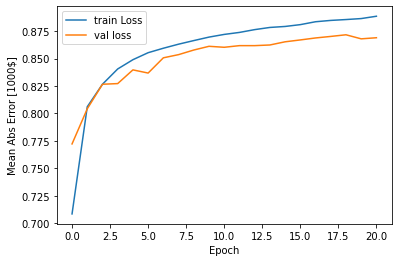

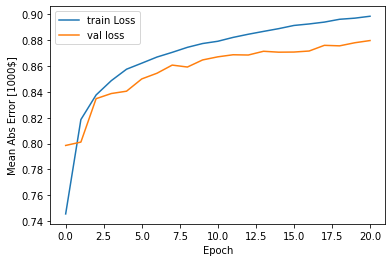

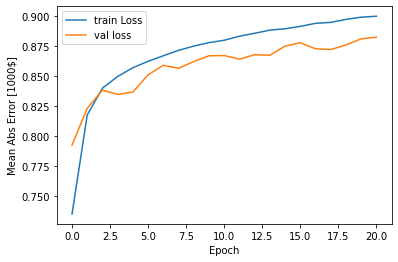

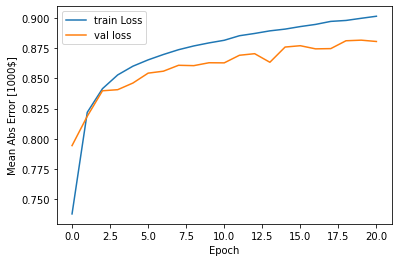

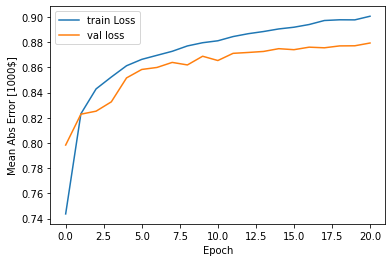

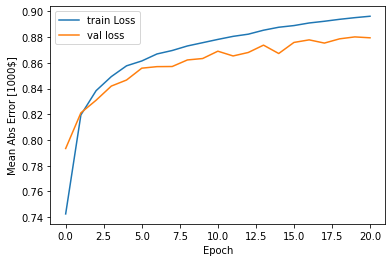

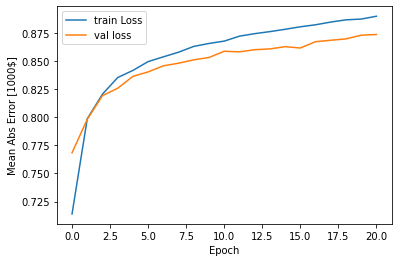

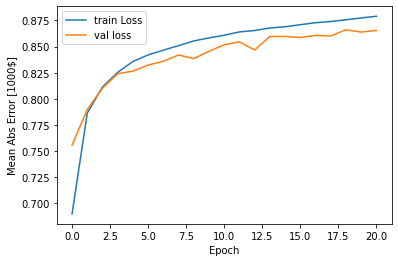

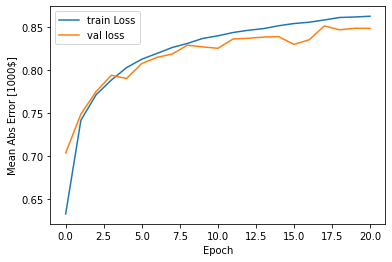

In [14]:
for history in models_dict['model_historys']:
    #keys_list = list(history.history.keys())
    #print(keys_list)
    plot_history(history)



## **Сложные конструкции из простых слоев**

Слой для объединения

https://keras.io/api/layers/merging_layers/concatenate/

In [ ]:

from tensorflow.keras.layers import Dense, Flatten, Concatenate

from tensorflow.keras.utils import plot_model 


Строим сеть из трех нитей

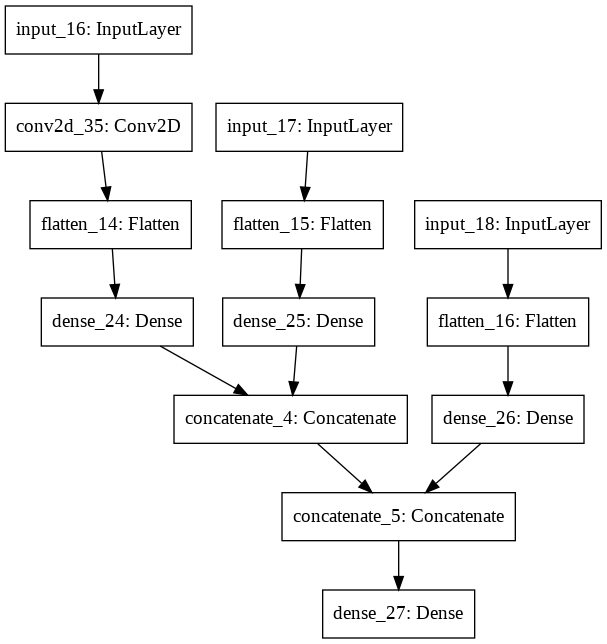

In [ ]:
first_input = Input(shape=(28,28,1 ))
x11= Conv2D(10,3,activation='relu')(first_input)
x11= Flatten()(x11)
first_dense = Dense(1, )(x11)

second_input = Input(shape=(28,28,1 ))
x22= Flatten()(second_input)
second_dense = Dense(1, )(x22)

merge_one = Concatenate( )([first_dense, second_dense])

third_input = Input(shape=(28,28,1 ))
x33= Flatten()(third_input)
x33 = Dense(1, )(x33)
merge_two = Concatenate(axis=1)([merge_one, x33])
merge_two=Dense(10, activation='softmax')(merge_two)


model_stek = Model(inputs=[first_input, second_input, third_input], outputs=merge_two)
ada_grad = tf.keras.optimizers.Adagrad(lr=0.1, epsilon=1e-08, decay=0.0)
model_stek.compile(optimizer=ada_grad, loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])


plot_model(model_stek,'model_stek.png')



In [ ]:
model_stek.summary()

Model: "model_23"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_16 (InputLayer)           [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_35 (Conv2D)              (None, 26, 26, 10)   100         input_16[0][0]                   
__________________________________________________________________________________________________
input_17 (InputLayer)           [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
flatten_14 (Flatten)            (None, 6760)         0           conv2d_35[0][0]                  
___________________________________________________________________________________________

In [ ]:
hist = model_stek.fit([x_train,x_train,x_train],y_train, epochs = 5, validation_split=0.2)

Epoch 1/5
1500/1500 [==============================] - 5s 3ms/step - loss: 0.8880 - accuracy: 0.6718 - val_loss: 0.5768 - val_accuracy: 0.7919
Epoch 2/5
1500/1500 [==============================] - 4s 3ms/step - loss: 0.5605 - accuracy: 0.8045 - val_loss: 0.5190 - val_accuracy: 0.8188
Epoch 3/5
1500/1500 [==============================] - 4s 3ms/step - loss: 0.5060 - accuracy: 0.8262 - val_loss: 0.5007 - val_accuracy: 0.8288
Epoch 4/5
1500/1500 [==============================] - 4s 3ms/step - loss: 0.4977 - accuracy: 0.8293 - val_loss: 0.4892 - val_accuracy: 0.8299
Epoch 5/5
1500/1500 [==============================] - 4s 3ms/step - loss: 0.4684 - accuracy: 0.8382 - val_loss: 0.4768 - val_accuracy: 0.8374


## Пример на Keras более сложной сверточной нейронной сети

Давайте теперь попробуем сделать несколько усложненный вариант нейронной сети разобранной ранее. В ней будет на несколько слоев больше и в ней будет использоваться data augumentation, процедура позволяющая за счет искажений изображений увеличить количество тренировочных данных, а как мы знаем чем больше тренировочных данных тем лучше будет работать нейросеть. Для обучения нейросети будем использовать датасет cifar-10. В нем 10 категорий объектов, например - лошадь, лягушка, корабль. Данный датасет уже более сложен для нейронных сетей чем mnist, однако он намного проще датасетов наподобие imagenet где используются сотни классов и архитектуры нейронных сетей для подобных датасетов также понадобяться более сложные.

In [ ]:
from __future__ import print_function
#import tensorflow.keras as keras # расскоментируйте эту строку, чтобы начать обучение
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
import os

In [ ]:
classes=['самолет', 'автомобиль', 'птица', 'кот', 'олень', 'собака', 'лягушка', 'лошадь', 'корабль', 'грузовик']

In [ ]:
# установка параметров нейросети
batch_size = 32
num_classes = 10
epochs = 5
data_augmentation = False
num_predictions = 20
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'keras_cifar10_trained_model.h5'

In [ ]:
# разделение тренировочной и тестовой выборки
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'тренировочные примеры')
print(x_test.shape[0], 'тестовые примеры')

# преобразование матрицы чисел 0-9 в бинарную матрицу чисел 0-1
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)


x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

x_train shape: (50000, 32, 32, 3)
50000 тренировочные примеры
10000 тестовые примеры


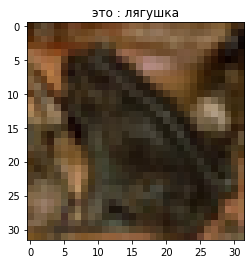

In [ ]:
N = 30

plt.imshow(x_test[N][:,:,:])
plt.title('это : '+classes[np.argmax(y_test[N,:])])
plt.show()

In [ ]:
# конфигурирование слоев нейросети
model = Sequential()

# слои нейросети отвественные за свертку и max-pooling
model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=x_train.shape[1:]))
model.add(Activation('relu'))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout( 0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# полносвязные слои нейронной сети
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

# инициализация RMSprop optimizer
#opt = tensorflow.keras.optimizers.RMSprop(lr=0.0001, decay=1e-6)

# компиляция модели
model.compile(loss='categorical_crossentropy',
              optimizer='SGD',
              metrics=['accuracy'])




if not data_augmentation:
    print('Не используется data augmentation')
    model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True)
else:
    print('Использование data augmentation в реальном времени')
    # Препроцессинг и data augmentation в реальном времени:
    datagen = ImageDataGenerator(
        featurewise_center=False,
        samplewise_center=False,
        featurewise_std_normalization=False,
        samplewise_std_normalization=False,
        zca_whitening=False, 
        zca_epsilon=1e-06, 
        rotation_range=0, 
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0., 
        zoom_range=0., 
        channel_shift_range=0.,
        fill_mode='nearest',
        cval=0.,
        horizontal_flip=True,
        vertical_flip=False,
        rescale=None,
        preprocessing_function=None,
        data_format=None,
        validation_split=0.0)

    # запуск data augmentation через fit
    #datagen.fit(x_train)

    # запуск data augmentation через fit_generator
    model.fit_generator(datagen.flow(x_train, y_train,
                                     batch_size=batch_size),
                        epochs=epochs,
                        validation_data=(x_test, y_test),
                        workers=4)

# сохранение модели и весов
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('сохранить обученную модель как %s ' % model_path)

# проверка работы обученной модели
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

Не используется data augmentation
Epoch 1/5
1563/1563 [==============================] - 8s 5ms/step - loss: 2.2130 - accuracy: 0.1628 - val_loss: 1.8209 - val_accuracy: 0.3455
Epoch 2/5
1563/1563 [==============================] - 7s 4ms/step - loss: 1.7640 - accuracy: 0.3540 - val_loss: 1.6078 - val_accuracy: 0.4231
Epoch 3/5
1563/1563 [==============================] - 7s 5ms/step - loss: 1.5614 - accuracy: 0.4276 - val_loss: 1.4730 - val_accuracy: 0.4504
Epoch 4/5
1563/1563 [==============================] - 7s 4ms/step - loss: 1.4365 - accuracy: 0.4794 - val_loss: 1.2816 - val_accuracy: 0.5388
Epoch 5/5
1563/1563 [==============================] - 7s 5ms/step - loss: 1.3503 - accuracy: 0.5147 - val_loss: 1.3259 - val_accuracy: 0.5204
сохранить обученную модель как /content/saved_models/keras_cifar10_trained_model.h5 
313/313 [==============================] - 1s 3ms/step - loss: 1.3259 - accuracy: 0.5204
Test loss: 1.3258932828903198
Test accuracy: 0.5203999876976013


Что вернет ImageDataGenerator

In [ ]:
datagen = ImageDataGenerator(
        featurewise_center=False,
        samplewise_center=False,
        featurewise_std_normalization=False,
        samplewise_std_normalization=False,
        zca_whitening=False, 
        zca_epsilon=1e-06, 
        rotation_range=0, 
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0., 
        zoom_range=0., 
        channel_shift_range=0.,
        fill_mode='nearest',
        cval=0.,
        horizontal_flip=True,
        vertical_flip=False,
        rescale=None,
        preprocessing_function=None,
        data_format=None,
        validation_split=0.0)

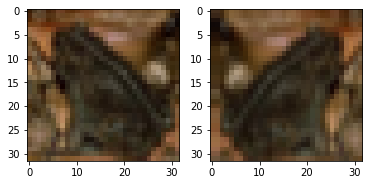

In [ ]:
datagen.fit(x_test)
for imag,y  in datagen.flow(x_test[N:N+1,:,:,:],y_test[N:N+1], batch_size=1):
  plt.subplot(1,2,1)
  plt.imshow(x_test[N][:,:,:])
  plt.subplot(1,2,2)
  plt.imshow(imag[0,:,:,:])

  plt.show()
  if True:
    break


In [ ]:
 model.fit_generator(datagen.flow(x_train, y_train,
                                     batch_size=batch_size),
                        epochs=epochs,
                        validation_data=(x_test, y_test))

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/5
1563/1563 [==============================] - 25s 16ms/step - loss: 1.3769 - accuracy: 0.5045 - val_loss: 1.1755 - val_accuracy: 0.5805
Epoch 2/5
1563/1563 [==============================] - 25s 16ms/step - loss: 1.3219 - accuracy: 0.5247 - val_loss: 1.1612 - val_accuracy: 0.5852
Epoch 3/5
1563/1563 [==============================] - 26s 16ms/step - loss: 1.2777 - accuracy: 0.5437 - val_loss: 1.1029 - val_accuracy: 0.6112
Epoch 4/5
1563/1563 [==============================] - 25s 16ms/step - loss: 1.2268 - accuracy: 0.5597 - val_loss: 1.1355 - val_accuracy: 0.5960
Epoch 5/5
1563/1563 [==============================] - 25s 16ms/step - loss: 1.1895 - accuracy: 0.5763 - val_loss: 1.0333 - val_accuracy: 0.6349


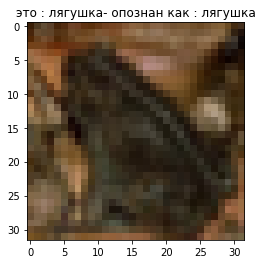

In [ ]:
N = 30
y_p=model.predict(x_test[N:N+1][:,:,:])
y_t = np.argmax(y_test[N:N+1], axis = 1 )
y_i = np.argmax(y_p, axis = 1 )
plt.imshow(x_test[N][:,:,:])
plt.title('это : '+classes[y_t[0]]+'- опознан как : '+classes[y_i[0]])
plt.show()

## Дополнительные материалы

<ol>
    <li>https://keras.io/layers/convolutional/</li>
    <li>https://keras.io/layers/pooling/</li>
    <li>https://keras.io/preprocessing/image/</li>
</ol>

## Используемая литература 

Для подготовки данного методического пособия были использованы следующие ресурсы:
<ol>
    <li>https://keras.io</li>
    <li>Шакла Н. — Машинное обучение и TensorFlow 2019</li>
    <li>Николенко Сергей Игоревич, Кадурин А. А. - Глубокое обучение. Погружение в мир нейронных сетей  2018</li>
    <li>Francois Chollet - Deep Learning with Python 2018</li>
    <li>Alex Krizhevsky, Ilya Sutskever, Geoffrey E. Hinton - ImageNet Classification with Deep Convolutional Neural Networks</li>
    <li>Karen Simonyan, Andrew Zisserman - Very Deep Convolutional Networks for Large-Scale Image Recognition</li>
    <li>Википедия</li>    
</ol>

In [ ]:
from tensorflow.keras.datasets import imdb

In [ ]:
(x,y),(d,h) =imdb.load_data(path='imdb.npz')

17465344/17464789 [==============================] - 0s 0us/step


<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/datasets/imdb.py:159: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/datasets/imdb.py:160: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 

In [ ]:
(np.array(x[0])==22).sum()

6

In [ ]:
h[0]

0